In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-ticks', 'seaborn-talk'])

import numpy as np
import pandas as pd
import xarray as xr

# Data Processing

Here, we take some of the archived data from Fernando's IGSM-CAM-GEOS-Chem ensemble and re-process it a bit to create a simpler dataset for playing with statistical meteorology-PM2.5 relationships. We similarly will extract some of Lu Shen's post-processed observational data, which he used in his 2017 paper.

Our major goal here is to subset the data for a small box around Boston.

In [35]:
fgm_ensemble = (
    xr.open_dataset("../data/fgm.all_cases.usa_subset.nc")
      .sel(pol='REF', ic=1, dec='1980-2010')
      .drop(['pol', 'ic', 'cs', 'dec', 'lev'])
      .load()
)
fgm_ensemble.info()

# ... remove the trend from -- all -- the data

xarray.Dataset {
dimensions:
	lat = 15 ;
	lon = 24 ;
	time = 359 ;

variables:
	float64 lat(lat) ;
		lat:long_name = latitude ;
		lat:units = degrees_north ;
	float64 lon(lon) ;
		lon:long_name = longitude ;
		lon:units = degrees_east ;
	datetime64[ns] time(time) ;
		time:long_name = time ;
		time:bounds = time_bnds ;
	float64 PM25(time, lat, lon) ;
		PM25:units = ug/m3 ;
		PM25:long_name = Particulate matter >2.5 micron ;
	float64 TEMP(time, lat, lon) ;
		TEMP:units = K ;
		TEMP:long_name = Temperature ;
		TEMP:cell_methods = time: mean ;
	float64 PRECIP(time, lat, lon) ;
		PRECIP:long_name = Precipitation ;
		PRECIP:units = mm/day ;
	float64 RH(time, lat, lon) ;
		RH:mdims = 1 ;
		RH:units = % ;
		RH:cell_methods = time: mean ;
		RH:long_name = Relative humidity ;
	float64 U(time, lat, lon) ;
		U:mdims = 1 ;
		U:units = m/s ;
		U:cell_methods = time: mean ;
		U:long_name = Zonal winds ;
	float64 V(time, lat, lon) ;
		V:mdims = 1 ;
		V:units = m/s ;
		V:cell_methods = time: mean ;
		V

What does the linear trend in temperature look like over the model domain?

        time        test  idx
0 1981-01-01  287.255334    0
1 1982-01-01  286.941639    1
2 1983-01-01  287.715105    2
3 1984-01-01  287.628844    3
4 1985-01-01  287.612774    4


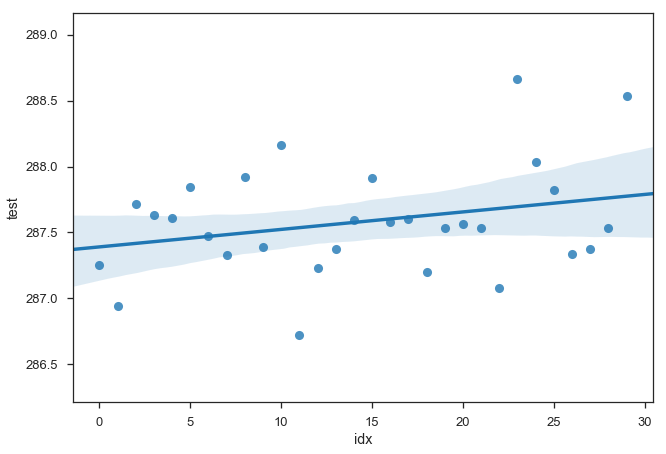

In [4]:
# Select temperature data
t = fgm_ensemble['TEMP']
ds = t.mean(['lat', 'lon'])

# Re-sample annualy
ds_yearly = ds.resample(time='AS').mean()

# Convert to dataframe for plotting
df = ds_yearly.to_dataframe('test').reset_index()
df['idx'] = range(len(df))
print(df.head())

import seaborn as sns

sns.regplot('idx', 'test', df)

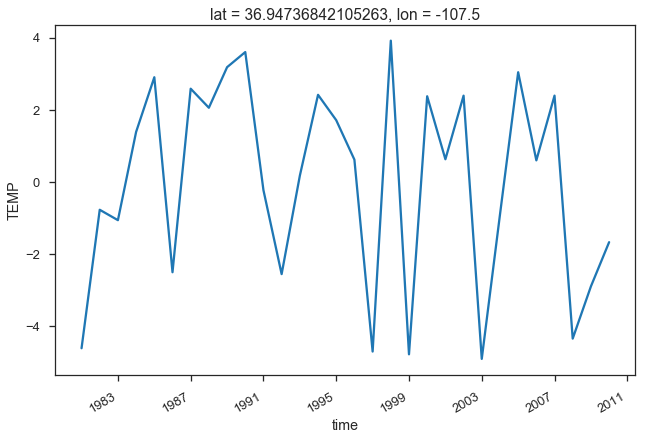

In [110]:
t = fgm_ensemble['TEMP']
ds = t.isel(lat=7, lon=7)
ms = MonthSelector(1, width=0)
ds = ms.fit_transform(ds)

(ds - ds.mean('time')).plot()

# Basic Example

For a simple example of how to use this toolkit, let's look at the following simple Principal Component Regression model, adapted from the example in [stat_pm25/models/simple.py]():

In [90]:
from stat_pm25.sklearn import *

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression


class PCRModel(DatasetModel):
    """ Performs principal component regression model on gridded data.

    This class uses the `DatasetModel` framework to implement a principal
    component regression - a linear regression on a set of features which has
    been pre-processed using principal component analysis. It only requires a
    single additional argument on top of `DatasetModel`, the number of
    components to retain.

    This example illustrates how you can very easily put together complex
    analyses and deploy them onto your gridded model output, all using very
    simple building blocks.

    """

    def __init__(self, *args, n_components=3, month=6, **kwargs):
        # If you need to add arguments, add them as named keyword arguments in
        # the appropriate place (as shown above), and set them first in the
        # method.
        self.n_components = n_components
        self.month = month
        
        # Modify any pre-set parameters, or hard-code them otherwise. For
        # instance, if you want to pre-process your data, this would be the
        # place to specify how to do so. Doing so here has the advantage that
        # you will be able to immediately apply your `predict()` method
        # to new data without pre-processing it - all that logic will be
        # saved

        # Zero out dilat and dilon, since we don't need to search around
        # neighboring grid cells
        self.dilat = self.dilon = 0

        # Set a pre-processor pipeline
        self.preprocessor = Pipeline([
            ('subset_time', MonthSelector(self.month, width=0)),
            # We didn't include the de-trending component below
            ('detrend', YearlyMovingAverageDetrender())
        ])
        
        # Call the parent superconstructor
        super().__init__(*args, **kwargs)

    def cell_kernel(self, gcf):
        """ Fit a model at a single grid cell.

        """

        # First, get the predictand data at the grid cell we care about. We
        # don't necessarily have to be super pedantic about this; we can just
        # use normal xarray selection methods if we want, although comments
        # below is how we could accomplish this using our specialized
        # Transformer classes
        # local_selector = DatasetSelector(
        #     sel='isel', lon=gcf.ilon, lat=gcf.ilat
        # )
        # y = local_selector.fit_transform(self.data[self.predictand])
        y = self.data[self.predictand].isel(lat=gcf.ilat, lon=gcf.ilon)

        # Prepare features timeseries. We want to fully include all the steps
        # to extract our features from the original, full dataset in here
        # so that our logic for re-applying the pipeline for prediction
        # later on will work similarly
        _model = Pipeline([
            ('subset_latlon', DatasetSelector(
                sel='isel', lon=gcf.ilon, lat=gcf.ilat)
            ),
            ('predictors', FieldExtractor(self.predictors)),
            ('normalize', Normalizer()),
            ('dataset_to_array', DatasetAdapter(drop=['lat', 'lon'])),
            ('pca', PCA(n_components=self.n_components)),
            ('linear', LinearRegression()),
        ])

        # Fit the model/pipeline
        _model.fit(self.data, y)
        # Calculate some sort of score for archival
        _score = _model.score(self.data, y)
        # Encapsulate the result within a GridCellResukt
        gcr = GridCellResult(_model, self.predictand, self.predictors, 
                             _score, rand=np.random.randint(10), x=1)
        
        return gcr

Set up the model and fit it.

In [91]:
predictand = 'PM25'
predictors = ['TEMP', 'RH', 'PRECIP', 'U', 'V']

train_data = fgm_ensemble.isel(time=slice(0, 12*25))
test_data = fgm_ensemble.isel(time=slice(12*25, None))

model = PCRModel(train_data, predictand, predictors, month=1,
                 verbose=True)
model.fit_parallel(3)

Loop over all grid cells:   0%|          | 0/360 [00:00<?, ?it/s]

Fitting pre-processor...


Loop over all grid cells: 100%|██████████| 360/360 [00:02<00:00, 148.95it/s]


Time elapsed =  1.5898650000000032


In [95]:
test_pm25 = model.predict(test_data, preprocess=True)

Iterate over grid cell models:   6%|▌         | 22/360 [00:00<00:01, 214.11it/s]

Pre-processing data...


Iterate over grid cell models: 100%|██████████| 360/360 [00:01<00:00, 250.34it/s]


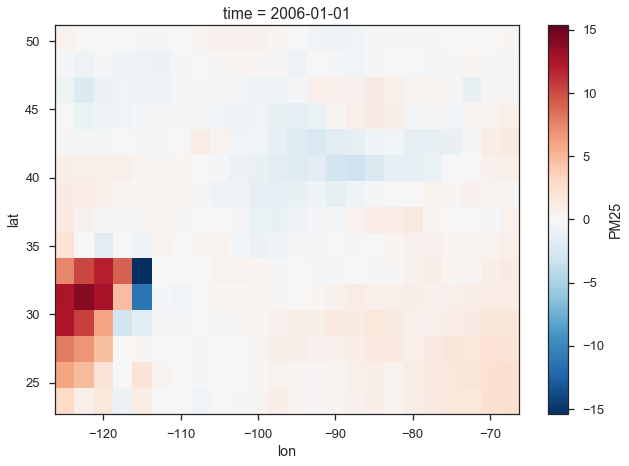

In [97]:
test_pm25.PM25.isel(time=0).plot.imshow()

Ploting the fitted model `score`s in each grid cell.

Iterate over grid cell models: 100%|██████████| 360/360 [00:00<00:00, 552285.82it/s]


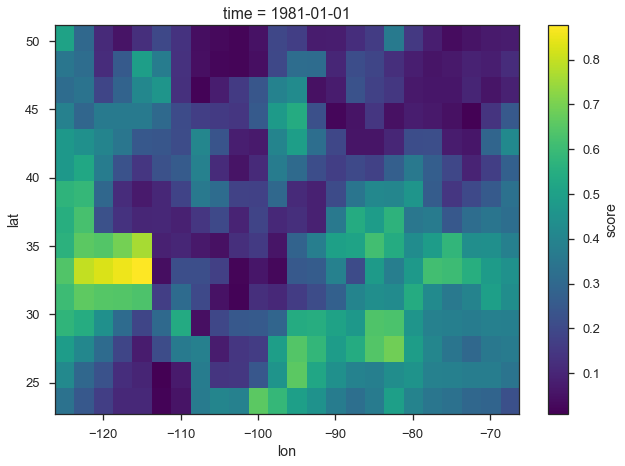

In [67]:
score = model.score
score.plot.imshow()

Retreiving an saved result attribute and plotting.

Iterate over grid cell models: 100%|██████████| 360/360 [00:00<00:00, 271086.08it/s]


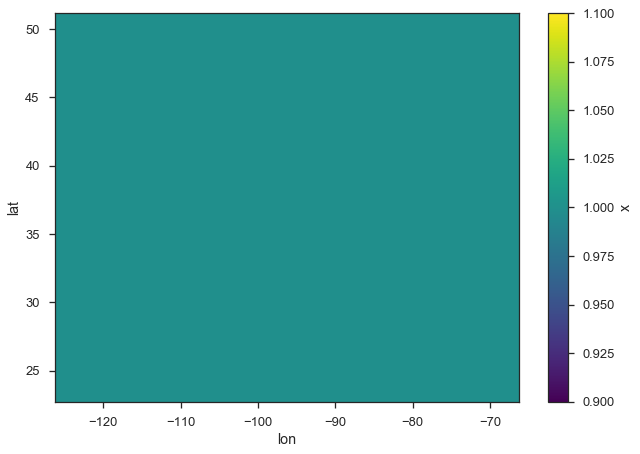

In [72]:
rand = model.get_result_stat('x')['x']
rand.plot.imshow()

Iterating over the model `GridCellResult`s.

In [73]:
for gcr, gcf in model._gcr_gcf_iter:
    print(gcr)

Iterate over grid cell models: 100%|██████████| 360/360 [00:00<00:00, 7114.05it/s]

GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.336444]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.416509]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.488181]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.577908]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.605604]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.641537]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.568552]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.552694]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.574842]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.47284]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.473479]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.39]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.315176]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.351231]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.510182]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.246934]
GridCellResul

# "Stack" ensemble members

The idea here is to take our 5 independent, 30 year simulations into a single collection of timestamps. If we've properly "un-parameterized" the timeseries aspect of the data, then this allows us to greatly increase the number of samples available for an analysis.

A generalized version of this method can be found at `stat_pm25.util.flatten_times()`.

As an example, here's how this might work for some domain-average temperature data.

/Users/daniel/anaconda/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


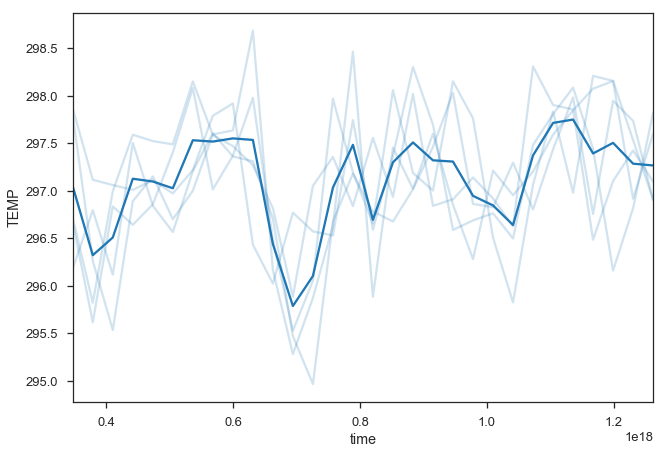

In [4]:
import xarray as xr
import seaborn as sns

t = (
    xr.open_dataset("../data/fgm.all_cases.usa_subset.nc")
    ['TEMP']
    .sel(dec='1980-2010', pol='REF')
    .mean(['lat', 'lon'])
    .drop(['pol', 'cs', 'dec', 'lev'])
    .resample(time='AS').max('time')
)
t_df = t.to_dataframe().reset_index()
sns.tsplot(t_df, 'time', 'ic', value='TEMP', err_style='unit_traces')

The basic idea is that our data has at least two dimensions - a "time" dimension and a "unit" dimension, indicating an independent set of time samples. In this case, the "unit" dimension (`aux_times`) is **ic**. We're simply going to unravel that dimension, and sequentially re-index our data.

In [28]:
ds = t.copy()

time = 'time'
aux_times = 'ic'

nt = len(ds[time])

# Loop over all the unit dim values
_dss = []
for i in range(len(ds[aux_times])):
    ds_aux_i = ds.isel(**{aux_times: i})
    
    # NOTE: Assume that our time offset will be in years, and that we can
    #       safely cast the existing timeseries to monthly values
    delta = np.timedelta64(nt*i, 'Y')
    ds_aux_i[time].values = \
        ds_aux_i[time].values.astype('datetime64[M]') + delta
        
    _dss.append(ds_aux_i)
    
ds_flat = xr.concat(_dss, time)

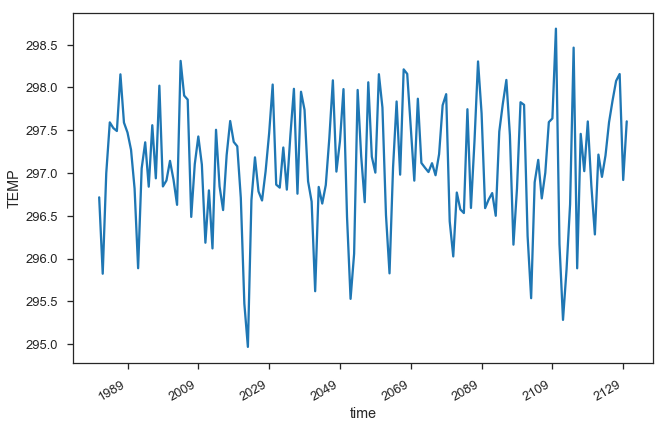

In [29]:
ds_flat.plot()

# Linear Regression w/ Neighbor

We're going to re-implement a similar analysis to the `PCRModel` from before, but now we're going to include a special `Pipeline`/`Transformer` element which will grab the values of temperature at neighboring cells and include them as features in the model.

I'll skip comments that are in the original `PCRModel` code and only focus on documenting stuff that is new.

The key point here is to use a `DatasetFeatureUnion` to merge two `Pipeline`s. You can think of an individual `Pipeline` as a way to transform an input dataset into some form which can be run through a scikit-learn model. That includes creating sets of features. A `DatasetFeatureUnion` lets you take a set of `Pipeline`s which create different features and mash them together before feeding into a model.

In [151]:
from stat_pm25.sklearn import *

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression


class NeighborhoodFeatures(TransformerMixin, NoFitMixin):
    """ Given a subset of a Dataset, extract a feature for
    each value along a given dimension.
    
    """
    
    def __init__(self, feature, dim='cell'):
        self.feature = feature
        self.dim = dim
    
    def transform(self, X, y=None):
        # Copy our dataset
        feats = X.copy().drop([feature, ])
        feat_names = []
        for i in range(len(X[dim])):
            _ds = X.isel(**{dim: i})
            feat_name = '{}_{:d}'.format(feature, i)
            feats[feat_name] = _ds
        feats = feats[feat_names]
        
        return feats        


class LocalModel(DatasetModel):
    """ Performs a simple linear regression between local predictands
    and features generated from area-averaging around each cell as well
    as sampling from around that cell.

    """

    def __init__(self, *args, n_components=3,  **kwargs):
        self.n_components = n_components

        # This time, we *do* need dilat/dilon, since we need to be able
        # to search a radius around each cell. Let's choose a radius of 1,
        # which will search for one cell in each direction.
        self.dilat = 1
        self.dilon = 1

        # Set a pre-processor pipeline
        self.preprocessor = None
        
        # Call the parent superconstructor
        super().__init__(*args, **kwargs)

    def cell_kernel(self, gcf):
        """ Fit a model at a single grid cell.

        """
        # Select just the values at the local grid cell
        local_selector = DatasetSelector(sel='isel', lon=gcf.ilon, lat=gcf.ilat)
        # Select the set of values within a grid cell's neighborhood
        area_selector = DatasetSelector(sel='isel',
                                        lon=gcf.ilon_range, lat=gcf.ilat_range)
        
        y = self.data[self.predictand].isel(lat=gcf.ilat, lon=gcf.ilon)

        # Select temperatures in an area around the local grid cell,
        # and average over them
        local_area_average_pipeline = Pipeline([
            ('get_temp', FieldExtractor(['TEMP', ])),
            ('get_local_area', area_selector),
            ('area_avg', DatasetFunctionTransformer('mean', 
                                                    args=(['lat', 'lon'],)
            )),
        ])
        
        # Select temperatures at the surrounding grid cells
        neighborhood_pipeline = Pipeline([
            ('get_temp', FieldExtractor(['TEMP', ])),
            ('get_local_area', area_selector),
            ('stack', Stacker(['lon', 'lat'], 'cell')),
            ('get_neighbors', NeighborhoodFeatures('TEMP', ))                        
        ])
        
        # Prepare features timeseries. We want to fully include all the steps
        # to extract our features from the original, full dataset in here
        # so that our logic for re-applying the pipeline for prediction
        # later on will work similarly
        _model = Pipeline([
            ('subset_latlon', DatasetSelector(
                sel='isel', lon=gcf.ilon, lat=gcf.ilat)
            ),
            # Here we "branch" the pipeline to extract three sets of 
            # features to merge:
            ('make_features', DatasetFeatureUnion([
                # 1) Just the local predictors at the current grid cell
                ('local_predictors', FieldExtractor(self.predictors)),
                # 2) Our saved area average temperature pipeline
                ('area_avg_feature', local_area_average_pipeline),
                # 3) Our saved neighborhood temperatures pipeline
                # ('neighborhood_features', neighborhood_pipeline)
            ])),
            ('normalize', Normalizer()),
            ('dataset_to_array', DatasetAdapter(drop=['lat', 'lon'])),
            ('pca', PCA(n_components=self.n_components)),
            ('linear', LinearRegression()),
        ])

        # Fit the model/pipeline
        _model.fit(self.data, y)
        # Calculate some sort of score for archival
        _score = _model.score(self.data, y)
        # Encapsulate the result within a GridCellResukt
        gcr = GridCellResult(_model, self.predictand, self.predictors, 
                             _score, rand=np.random.randint(10), x=1)
        
        return gcr

In [150]:
gcf = GridCellFactor(5, 5, 1, 1)
fe = FieldExtractor(['TEMP', ])
area_selector = DatasetSelector(sel='isel',
                                lon=gcf.ilon_range, lat=gcf.ilat_range)
pp = Pipeline([
    ('e', fe), ('a', area_selector),
    ('area_avg', DatasetFunctionTransformer('mean', 
                                            args=(['lat', 'lon'],)))
])
area_selector.transform(fgm_ensemble)
fe.transform(fgm_ensemble)
pp.transform(fgm_ensemble)

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:  (lat: 3, lon: 3, time: 359)
Coordinates:
  * lat      (lat) float64 29.37 31.26 33.16
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 1981-03-01 ...
  * lon      (lon) float64 -117.5 -115.0 -112.5
Data variables:
    TEMP     (time, lat, lon) float64 288.9 288.7 287.6 287.2 284.8 283.9 ...
Attributes:
    History:  Generated by 09_lu_shen_reproduction.ipynb (Apr 19, 2017 13:49)\n> ['lat', 'lon']


<xarray.Dataset>
Dimensions:  (time: 359)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 1981-03-01 ...
Data variables:
    TEMP     (time) float64 285.0 288.7 289.7 293.1 294.2 298.0 299.2 300.8 ...

In [152]:
predictand = 'PM25'
predictors = ['TEMP', 'RH', 'PRECIP', 'U', 'V']

train_data = fgm_ensemble.isel(time=slice(0, 12*25))
test_data = fgm_ensemble.isel(time=slice(12*25, None))

model = LocalModel(train_data, predictand, predictors,
                   # lat_range=[25, 50], 
                   lat_range=[30, 35],
                   lon_range=[-120, -75],
                   verbose=True)
model.fit_parallel(3)



Loop over all grid cells:   0%|          | 0/360 [00:00<?, ?it/s]

Loop over all grid cells:   0%|          | 1/360 [00:00<01:17,  4.62it/s]

Loop over all grid cells:   2%|▏         | 8/360 [00:00<00:55,  6.39it/s]

Loop over all grid cells:   5%|▍         | 17/360 [00:00<00:38,  8.82it/s]

Loop over all grid cells:   7%|▋         | 24/360 [00:00<00:28, 11.92it/s]

Loop over all grid cells:   9%|▉         | 34/360 [00:00<00:20, 16.20it/s]

Loop over all grid cells:  13%|█▎        | 46/360 [00:00<00:14, 21.76it/s]/Users/daniel/workspace/stat_pm25/stat_pm25/sklearn.py:219: UserWarning: Fit failed at GridCellFactor - [2, 4]
  warnings.warn('Fit failed at {}'.format(gcf))
/Users/daniel/workspace/stat_pm25/stat_pm25/sklearn.py:219: UserWarning: Fit failed at GridCellFactor - [2, 5]
  warnings.warn('Fit failed at {}'.format(gcf))


Loop over all grid cells:  16%|█▋        | 59/360 [00:00<00:10, 28.92it/s]/Users/daniel/workspace/stat_pm25/stat_pm25/sklearn.py:219: UserWarning: Fit failed a



Loop over all grid cells:  89%|████████▉ | 321/360 [00:03<00:00, 117.03it/s]

Loop over all grid cells:  93%|█████████▎| 334/360 [00:03<00:00, 120.51it/s]

Loop over all grid cells:  97%|█████████▋| 348/360 [00:03<00:00, 124.44it/s]

Loop over all grid cells: 100%|██████████| 360/360 [00:03<00:00, 108.08it/s]

Time elapsed =  3.1046499999999924


In [106]:
rand = model.get_result_stat('rand')['rand']
rand.plot.imshow()



Iterate over grid cell models:   0%|          | 0/360 [00:00<?, ?it/s]

Iterate over grid cell models: 100%|██████████| 360/360 [00:00<00:00, 517992.95it/s]

ValueError: zero-size array to reduction operation minimum which has no identity